# CNN for AED with Keras/TensorFlow (living room)

Date: Nov 8, 2018

Data acquisition: living room

## Preparing data set for CNN

In [1]:
DATA_FOLDER = '../oscilloscope/data_living/'

FILTERS=40
FILES = 50
TRAINING_FILES = 40
TEST_FILES = FILES - TRAINING_FILES

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os
import sklearn.preprocessing as pp

In [3]:
import glob

data_files = glob.glob(DATA_FOLDER+'*mel_spectrogram*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*mel_spectrogram*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

LENGTH=64
a1, a2 = 0,  FILTERS*64
b1, b2 = FILTERS*64, FILTERS*64*2
c1, c2 = FILTERS*64*2, FILTERS*64*3

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        training_set.append((img1, class_number))
        training_set.append((img2, class_number))
        training_set.append((img3, class_number))
    files = v[1]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        test_set.append((img1, class_number))
        test_set.append((img2, class_number))
        test_set.append((img3, class_number))

random.shuffle(training_set)
random.shuffle(test_set)

class_labels = []

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k ))
    class_labels.append(k)

import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

len(training_set)

0: bathing
1: cocking
2: moving
3: silence
4: tooth_brushing
5: washing
6: watching_tv


840

C:\Users\shiny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


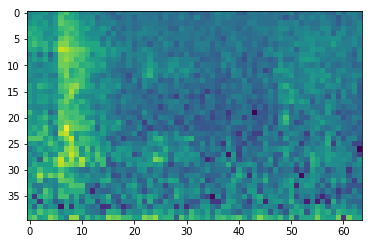

In [4]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data, dtype='float32').reshape((TRAINING_FILES*len(class_labels)*3, LENGTH, FILTERS, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data, dtype='float32').reshape((TEST_FILES*len(class_labels)*3, LENGTH, FILTERS, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(np.rot90(train_data[0, :,:,0]))

### CNN model

In [5]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(LENGTH, FILTERS, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 36, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 18, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 7, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2912)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                186432    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

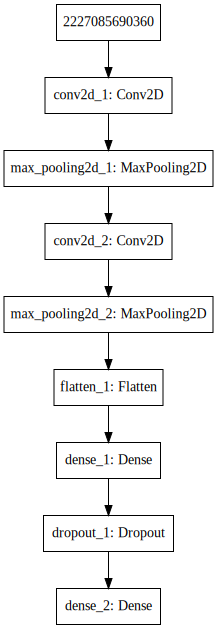

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [8]:
EPOCHS = 10
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 840 samples, validate on 210 samples
Epoch 1/10
840/840 [==============================] - 17s 20ms/step - loss: 1.2408 - acc: 0.5619 - val_loss: 0.7612 - val_acc: 0.7524
Epoch 2/10
840/840 [==============================] - 15s 17ms/step - loss: 0.6973 - acc: 0.7429 - val_loss: 0.6354 - val_acc: 0.8143
Epoch 3/10
840/840 [==============================] - 15s 18ms/step - loss: 0.5750 - acc: 0.8107 - val_loss: 0.5227 - val_acc: 0.7905
Epoch 4/10
840/840 [==============================] - 15s 18ms/step - loss: 0.5040 - acc: 0.8262 - val_loss: 0.4958 - val_acc: 0.8095
Epoch 5/10
840/840 [==============================] - 14s 17ms/step - loss: 0.3896 - acc: 0.8631 - val_loss: 0.5876 - val_acc: 0.8048
Epoch 6/10
840/840 [==============================] - 15s 18ms/step - loss: 0.3469 - acc: 0.8881 - val_loss: 0.5664 - val_acc: 0.8667
Epoch 7/10
840/840 [==============================] - 15s 17ms/step - loss: 0.3249 - acc: 0.9036 - val_loss: 0.6071 - val_acc: 0.8381
Epoch 8/10
840/8

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


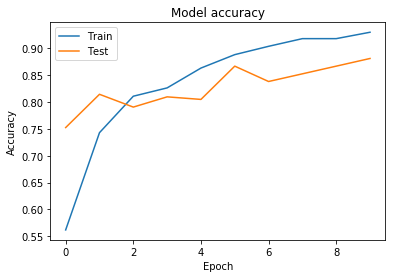

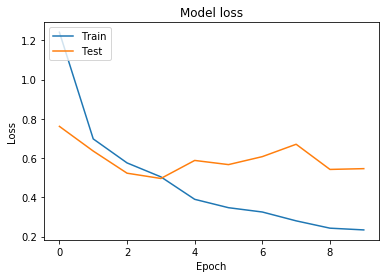

In [9]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [10]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_aed_living_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [11]:
del model
model = models.load_model(filename)

## Confirmation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(840, 64, 40, 1)

In [13]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [14]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

'washing'

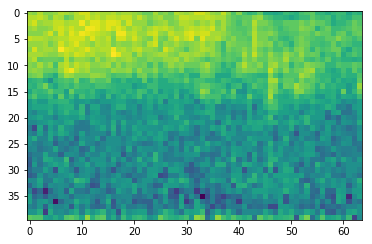

In [15]:
image_number = 22
plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

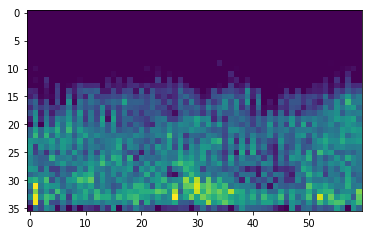

In [16]:
plt.imshow(np.rot90(activations[0][image_number,:,:,10]))

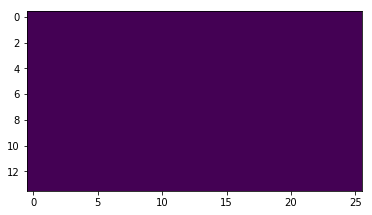

In [17]:
plt.imshow(np.rot90(activations[2][image_number,:,:,1]))

In [18]:
class_labels

['bathing',
 'cocking',
 'moving',
 'silence',
 'tooth_brushing',
 'washing',
 'watching_tv']

In [19]:
(activations[-1][:10]*100).astype(int)

array([[  0,   0,  99,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  99,   0],
       [100,   0,   0,   0,   0,   0,   0],
       [  0,  98,   1,   0,   0,   0,   0],
       [  0,   0,  97,   0,   0,   0,   2],
       [100,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  39,  59],
       [  0,   0,   0,   0,  99,   0,   0],
       [  0,  99,   0,   0,   0,   0,   0],
       [  0,   0,   3,   0,  94,   1,   0]])

In [20]:
test_labels[:10].astype(int)

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]])